## Module importation 

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from mpl_toolkits.axes_grid1 import make_axes_locatable

import scipy
import cv2 as cv

import h5py
import pickle
import os
import glob

# auto reload modules 
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('C:/Users/sebas/git')

import icewave.tools.datafolders as df
import icewave.tools.matlab2python as mat2py
import icewave.tools.matlab_colormaps as matcmaps
import icewave.sebastien.set_graphs as set_graphs
import icewave.tools.Fourier_tools as FT
import icewave.drone.drone_projection as dp

# PARULA COLORMAP 
parula_map = matcmaps.parula()

plt.rc('text', usetex=True)
plt.rc('font', family='serif', serif='Computer Modern')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Import data

In [162]:
base = 'K:/Share_hublot/Data/'
date = '0226'
drone_ID = 'mesange'
exp_ID = '12-FRAC_001'

path2data = f'{base}{date}/Drones/{drone_ID}/matData/{exp_ID}/'
filelist = glob.glob(f'{path2data}*scaled.mat')
print(filelist)

idx_file = 0
file2load = filelist[idx_file]

# load file 
with h5py.File(file2load, 'r') as fmat:
    S = {}

    print('Top-level keys : ', list(fmat.keys()))

    S = mat2py.mat_to_dict(fmat['m'],fmat['m'])
    S = mat2py.transpose_PIVmat_fields(S)

['K:/Share_hublot/Data/0226/Drones/mesange/matData/12-FRAC_001\\PIV_processed_i00_N0_Dt7_b1_W32_xROI1_width3839_yROI1_height2159_scaled.mat']
Top-level keys :  ['#refs#', 'm']


In [167]:
S['t0_UTC']

'2024-Feb-26 19:22:00.509'

#### Supress quadratic noise

In [57]:
Vx = FT.supress_quadratic_noise(np.transpose(S['Vx'],(1,0,2)),S['x'],S['y'])
Vy = FT.supress_quadratic_noise(np.transpose(S['Vy'],(1,0,2)),S['x'],S['y'])
Vx = np.transpose(Vx,(1,0,2))
Vy = np.transpose(Vy,(1,0,2))
Vx = np.flip(Vx,(0,1))
Vy = np.flip(Vy,(0,1))

print('Quadratic field supressed')

Supressing quadratic noise...
Quadratic noise supressed
Supressing quadratic noise...
Quadratic noise supressed
Quadratic field supressed


In [42]:
Vx.shape

(239, 102, 5151)

#### Compute angles $\theta$ and $\phi$ for all positions

In [25]:
xpix,ypix = np.meshgrid(S['PIXEL']['x_pix'],S['PIXEL']['y_pix'],indexing = 'xy')
beta_x,beta_y,beta_r = dp.get_angles(xpix,ypix, S['PIXEL']['x0'], S['PIXEL']['y0'], 
                                     S['DRONE']['focale'])
theta,phi = dp.get_theta_phi(xpix,ypix,S['PIXEL']['x0'], S['PIXEL']['y0'],S['DRONE']['focale'])

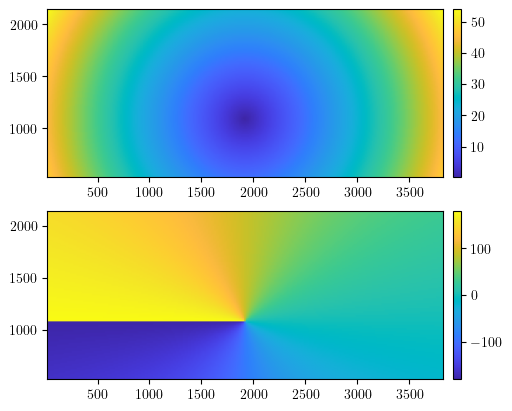

In [40]:
extents_meter = np.array([S['x'].min(),S['x'].max(),S['y'].min(),S['y'].max()])
extents_pix = np.array([S['PIXEL']['x_pix'].min(),S['PIXEL']['x_pix'].max(),
                    S['PIXEL']['y_pix'].min(),S['PIXEL']['y_pix'].max()])

fig, axs = plt.subplots(nrows = 2)
imsh = []
for i,ax in enumerate(axs):
    if i == 0:
        imsh.append(ax.imshow(theta*180/np.pi,cmap = parula_map,origin = 'lower',extent = extents_pix))
    else:
        imsh.append(ax.imshow(phi*180/np.pi,cmap = parula_map,origin = 'lower',extent = extents_pix))
    
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="2%", pad=0.1)
    cbar = plt.colorbar(imsh[i],cax = cax)

#### Plot fields 

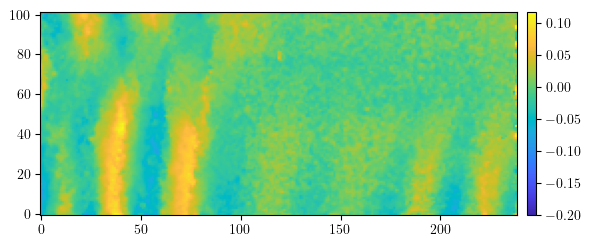

In [104]:
# select a frame and a x coordinate 
frame = 800
field = Vy[:,:,frame]
fig, ax = plt.subplots()
imsh = ax.imshow(field.T,cmap = parula_map,origin = 'lower',aspect = 'equal')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="2%", pad=0.1)
cbar = plt.colorbar(imsh,cax = cax)

In [104]:
# select a value of y
print(Vy.shape)

(239, 134, 5152)


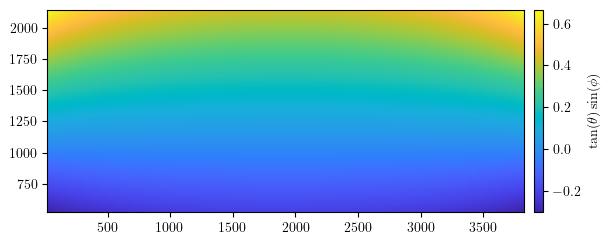

In [79]:
f_thetaphi_map = np.tan(theta.ravel())*np.sin(phi.ravel())
f_thetaphi_map = f_thetaphi_map.reshape(theta.shape)

fig, ax = plt.subplots()
imsh = ax.imshow(f_thetaphi_map,cmap = parula_map,origin = 'lower',extent = extents_pix,
         aspect = 'equal')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="2%", pad=0.1)
cbar = plt.colorbar(imsh,cax = cax)
cbar.set_label(r'$\tan(\theta)\sin(\phi)$')


#### Plot $V_y$ VS $\tan(\theta)\sin(\phi)$ for a given $X$ coordinate

In [74]:
Vy.shape

(239, 102, 5151)

[ 0.08556904 -0.0208167 ]


Text(0, 0.5, '$V_y$')

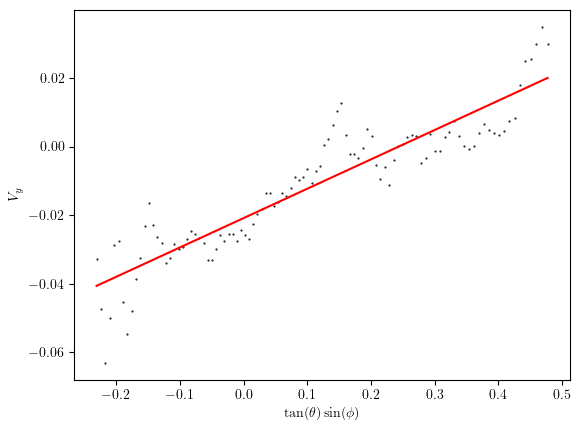

In [109]:
idx_x = 50
profile = field[idx_x,:]

f_thetaphi = np.tan(theta[:,idx_x])*np.sin(phi[:,idx_x])

# fit by a 1D polynome
p = np.polyfit(f_thetaphi,profile,1)
yth = np.polyval(p,f_thetaphi)


fig, ax = plt.subplots()
ax.plot(f_thetaphi,profile,'k.',ms = 1)
ax.plot(f_thetaphi,yth,'r')
ax.set_xlabel(r'$\tan(\theta)\sin(\phi)$')
ax.set_ylabel(r'$V_y$')

#### Compute $u_z(x,t)$

In [ ]:
uz = np.zeros((Vy.shape[0],Vy.shape[2])) # create array for uz

frame = 0
field = Vy[:,:,frame]

for idx_x in range(uz.shape[0]):
    f_thetaphi = np.tan(theta[:,idx_x])*np.sin(phi[:,idx_x])
    p = np.polyfit(f_thetaphi,field[idx_x,:],1)
    uz[idx_x,frame] = p[0]

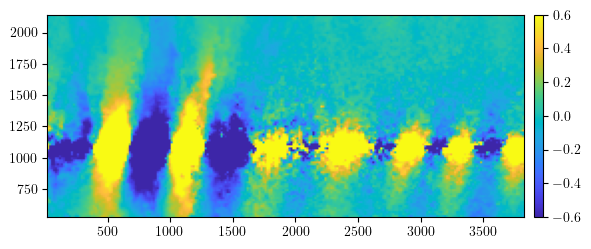

In [62]:
uz = field/np.tan(theta)/np.sin(abs(phi))
fig, ax = plt.subplots()
imsh = ax.imshow(uz,cmap = parula_map,origin = 'lower',extent = extents_pix,vmin = -0.6,vmax = 0.6)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="2%", pad=0.1)
cbar = plt.colorbar(imsh,cax = cax)

In [86]:
xpix.shape

(134, 239)

In [29]:
Lx = 3840
theta_x = np.atan(Lx/2700/2)
facq_pix = Lx / (2*119.5*np.tan(theta_x))
Dt = 7
facq_t = 30
scale_V = (facq_t/Dt)/facq_pix
print(scale_V)

0.18968253968253967
